# Lightgbm, double, discrepencies

Discrepencies usually happens with [lightgbm](https://lightgbm.readthedocs.io/en/latest/) because its code is used double to represent the threshold of trees as ONNX is using float only. There is no way to fix this discrepencies unless the ONNX implementation of trees is using double.

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
%load_ext mlprodict

## Simple regression problem

Target *y* is multiplied by 10 to increase the absolute discrepencies. Relative discrepencies should not change much.

In [3]:
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
X, y = make_regression(2000, n_features=10)
y *= 10
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

In [4]:
min(y), max(y)

(-5645.317056441552, 5686.0775071009075)

## Training a model

Let's train many models to see how they behave.

In [5]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

In [6]:
models = [
    RandomForestRegressor(n_estimators=50, max_depth=8),
    GradientBoostingRegressor(n_estimators=50, max_depth=8),
    HistGradientBoostingRegressor(max_iter=50, max_depth=8),
    LGBMRegressor(n_estimators=50, max_depth=8),
    XGBRegressor(n_estimators=50, max_depth=8),
]

In [7]:
from tqdm import tqdm
for model in tqdm(models):
    model.fit(X_train, y_train)

100%|██████████| 5/5 [00:01<00:00,  3.96it/s]


## Conversion to ONNX

We use function *to_onnx* from this package to avoid the trouble of registering converters from *onnxmltools* for *lightgbm* and *xgboost* libraries.

In [8]:
from mlprodict.onnx_conv import to_onnx
import numpy
onnx_models = [to_onnx(model, X_train[:1].astype(numpy.float32), rewrite_ops=True)
               for model in models]

C:\xavierdupre\__home_\github_fork\scikit-learn\sklearn\utils\deprecation.py:101: FutureWarning: Attribute n_features_ was deprecated in version 1.0 and will be removed in 1.2. Use 'n_features_in_' instead.
  warnings.warn(msg, category=FutureWarning)
C:\xavierdupre\__home_\github_fork\scikit-learn\sklearn\utils\deprecation.py:101: FutureWarning: Attribute n_classes_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


In [9]:
simple_onx = to_onnx(LGBMRegressor(n_estimators=3, max_depth=4).fit(X_train, y_train),
                     X_train[:1].astype(numpy.float32), rewrite_ops=True)
%onnxview simple_onx

## Discrepencies with float32

In [10]:
from onnxruntime import InferenceSession
from pandas import DataFrame


def max_discrepency(X, skl_model, onx_model):
    expected = skl_model.predict(X).ravel()
    
    sess = InferenceSession(onx_model.SerializeToString())
    got = sess.run(None, {'X': X})[0].ravel()
    
    diff = numpy.abs(got - expected).max()
    return diff


obs = []
x32 = X_test.astype(numpy.float32)
for model, onx in zip(models, onnx_models):
    diff = max_discrepency(x32, model, onx)
    obs.append(dict(name=model.__class__.__name__, max_diff=diff))

    
DataFrame(obs)

,name,max_diff
0,RandomForestRegressor,0.000493
1,GradientBoostingRegressor,0.000937
2,HistGradientBoostingRegressor,0.000794
3,LGBMRegressor,0.000924
4,XGBRegressor,0.000977


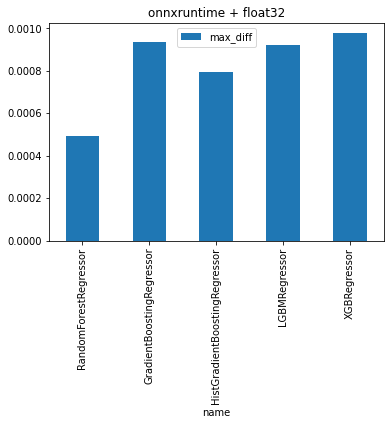

In [11]:
DataFrame(obs).set_index("name").plot(kind="bar").set_title("onnxruntime + float32");

## Discrepencies with mlprodict

This is not available with the current standard ONNX specifications. It required *mlprodict* to implement a runtime for tree ensemble supporting doubles.

In [12]:
from mlprodict.onnxrt import OnnxInference
from pandas import DataFrame


def max_discrepency_2(X, skl_model, onx_model):
    expected = skl_model.predict(X).ravel()
    
    sess = OnnxInference(onx_model)
    got = sess.run({'X': X})['variable'].ravel()
    
    diff = numpy.abs(got - expected).max()
    return diff


obs = []
x32 = X_test.astype(numpy.float32)
for model, onx in zip(models, onnx_models):
    diff = max_discrepency_2(x32, model, onx)
    obs.append(dict(name=model.__class__.__name__, max_diff=diff))

    
DataFrame(obs)

,name,max_diff
0,RandomForestRegressor,0.000798
1,GradientBoostingRegressor,0.001440
2,HistGradientBoostingRegressor,0.001082
3,LGBMRegressor,0.001288
4,XGBRegressor,0.000122


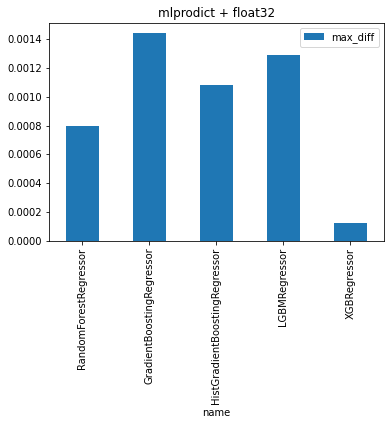

In [13]:
DataFrame(obs).set_index("name").plot(kind="bar").set_title("mlprodict + float32");

## Discrepencies with mlprodict and double

The conversion needs to happen again.

In [14]:
simple_onx = to_onnx(LGBMRegressor(n_estimators=2, max_depth=2).fit(X_train, y_train),
                     X_train[:1].astype(numpy.float64), rewrite_ops=True)
%onnxview simple_onx

C:\xavierdupre\microsoft_github\sklearn-onnx\skl2onnx\common\_container.py:603: UserWarning: Unable to find operator 'TreeEnsembleRegressorDouble' in domain 'mlprodict' in ONNX, op_version is forced to 1.
  warnings.warn(


In [15]:
onnx_models_64 = []
for model in tqdm(models):
    onx = to_onnx(model, X_train[:1].astype(numpy.float64), rewrite_ops=True)
    onnx_models_64.append(onx)

  0%|          | 0/5 [00:00<?, ?it/s]C:\xavierdupre\__home_\github_fork\scikit-learn\sklearn\utils\deprecation.py:101: FutureWarning: Attribute n_features_ was deprecated in version 1.0 and will be removed in 1.2. Use 'n_features_in_' instead.
  warnings.warn(msg, category=FutureWarning)
 20%|██        | 1/5 [00:02<00:09,  2.40s/it]C:\xavierdupre\__home_\github_fork\scikit-learn\sklearn\utils\deprecation.py:101: FutureWarning: Attribute n_classes_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)
100%|██████████| 5/5 [00:04<00:00,  1.16it/s]


In [16]:
obs64 = []
x64 = X_test.astype(numpy.float64)
for model, onx in zip(models, onnx_models_64):
    oinf = OnnxInference(onx)
    diff = max_discrepency_2(x64, model, onx)
    obs64.append(dict(name=model.__class__.__name__, max_diff=diff))

    
DataFrame(obs64)

,name,max_diff
0,RandomForestRegressor,2.273737e-12
1,GradientBoostingRegressor,9.094947e-13
2,HistGradientBoostingRegressor,9.094947e-13
3,LGBMRegressor,4.686752e-05
4,XGBRegressor,1.562066e-03


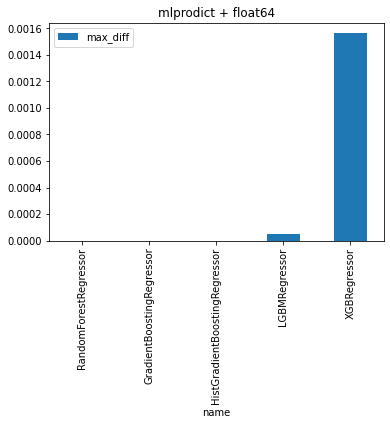

In [17]:
DataFrame(obs64).set_index("name").plot(kind="bar").set_title("mlprodict + float64");

In [18]:
df = DataFrame(obs).set_index('name').merge(DataFrame(obs64).set_index('name'),
                                              left_index=True, right_index=True)
df.columns = ['float32', 'float64']
df

,float32,float64
name,,
RandomForestRegressor,0.000798,2.273737e-12
GradientBoostingRegressor,0.001440,9.094947e-13
HistGradientBoostingRegressor,0.001082,9.094947e-13
LGBMRegressor,0.001288,4.686752e-05
XGBRegressor,0.000122,1.562066e-03


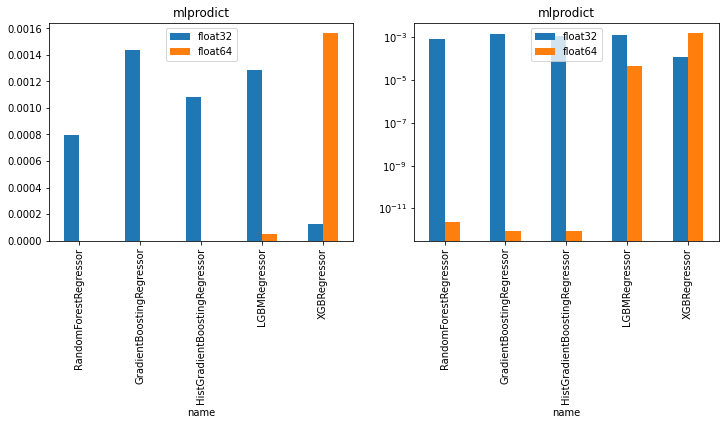

In [19]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
df.plot(kind="bar", ax=ax[0]).set_title("mlprodict")
df.plot(kind="bar", ax=ax[1], logy=True).set_title("mlprodict");

The runtime using double produces lower discrepencies except for *xgboost*. It is probably using float and all the others are using double.

**Note:** function [to_onnx](http://www.xavierdupre.fr/app/mlprodict/helpsphinx/mlprodict/onnx_conv/convert.html#mlprodict.onnx_conv.convert.to_onnx) automatically registers converters for *lightgbm*, *xgboost* and a dedicated runtime for a new ONNX node [TreeEnsembleRegressorDouble](http://www.xavierdupre.fr/app/mlprodict/helpsphinx/mlprodict/onnxrt/ops_cpu/op_tree_ensemble_regressor.html#mlprodict.onnxrt.ops_cpu.op_tree_ensemble_regressor.TreeEnsembleRegressorDouble). It uses [skl2onnx.to_onnx](https://onnx.ai/sklearn-onnx/api_summary.html#skl2onnx.to_onnx) underneath.